**Loading the Libraries & Data**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sb

import torch 
import torch.nn as nn
import torch.utils.data as td


jena_df = pd.read_csv("jena_climate_2009_2016.csv")

jena_df = jena_df.rename(columns={"Date Time": "DateTime", "p (mbar)": "Pressure", "T (degC)": "TempCelsius", "Tpot (K)": "TempKelvin", "Tdew (degC)": "TempDewCelsius",
                        "rh (%)": "RelativeHumidity", "VPmax (mbar)": "SatVapourPress", "VPact (mbar)": "VapourPressure", "VPdef (mbar)": "VapPressDeficit",
                        "sh (g/kg)": "SpecificHumidity", "H2OC (mmol/mol)": "WaterVapConc", "rho (g/m**3)": "AirDensity", "wv (m/s)": "WindSpeed",
                        "max. wv (m/s)": "MaxWindSpeed", "wd (deg)": "WindDirDegrees"})

__Data Preprocessing__

All these steps are explained in the data cleaning sheet and combined here in one cell for fast processing of the data.

In [2]:
#taking only the hourly values
jena_df = jena_df[5::6]

#removing incorrect values
jena_df['WindSpeed'].replace(-9999, 0, inplace = True)
jena_df['MaxWindSpeed'].replace(-9999, 0, inplace = True)

#treating outliers
def out_treat(var):
    Q1 = np.quantile(var.dropna(), 0.25)
    Q3 = np.quantile(var.dropna(), 0.75)
    IQR = Q3-Q1
    LC = Q1 - (3 * IQR)
    UC = Q3 + (3 * IQR)
    var[var > UC] = UC
    var[var < LC] = LC
    return (var)
jena_df = jena_df[~jena_df.index.duplicated()]

jena_df.Pressure = out_treat(jena_df.Pressure)
jena_df.SatVapourPress = out_treat(jena_df.SatVapourPress)
jena_df.VapPressDeficit = out_treat(jena_df.VapPressDeficit)
jena_df.AirDensity = out_treat(jena_df.AirDensity)

#deriving the wind vector components
wv = jena_df.pop('WindSpeed')
max_wv = jena_df.pop('MaxWindSpeed')
# Convert to radians.
wd_rad = jena_df.pop('WindDirDegrees')*np.pi / 180
# Calculate the wind x and y components.
jena_df['Wx'] = wv*np.cos(wd_rad)
jena_df['Wy'] = wv*np.sin(wd_rad)
# Calculate the max wind x and y components.
jena_df['max Wx'] = max_wv*np.cos(wd_rad)
jena_df['max Wy'] = max_wv*np.sin(wd_rad)

#drop variables that have redundant data (multicollinearity)
jena_df.drop(['TempCelsius'],axis=1,inplace=True)
jena_df.drop(['VapourPressure'],axis=1,inplace=True)
jena_df.drop(['WaterVapConc'],axis=1,inplace=True)

#setting datetime as the index
jena_df.set_index('DateTime',inplace=True, drop=True)

#Seperating the independent and dependent data
data = jena_df[["TempKelvin"]]

#Splitting the data for training and testing
test_size = round(len(data) * 0.2)
traindf = data[:-test_size]
testdf = data[-test_size:]

#Scaling - Fit and Transform TRAIN data
min_max_scaler = MinMaxScaler()
trainsc = min_max_scaler.fit_transform(traindf)
testsc = min_max_scaler.transform(testdf)

#Converting back to Pandas dataframe
traindf = pd.DataFrame(trainsc, columns = traindf.columns, index = traindf.index)
testdf = pd.DataFrame(testsc, columns = testdf.columns, index = testdf.index)

#concatenating train and test data
data = traindf.append(testdf)

__Creating Sequences & Transforming to tensors__

Step by Step Explanation:

1] Creating sequences of 168 lags (1 week of historical data)taken for all the data.

2] Splitting the data into train and test section as decided before.

3] Slicing the numpy arrays from both train and test data to create sequences train_x, train_y, test_x and test_y. (Keeping the mind the offset decided: 24 - predicting 
temperature after 24 hours)

4] Transforming the numpy arrays into PyTorch tensors.

5] Joining input sequences tensors with output sequences tensors.

6] Defining batch size for train and test data and creating data loader files for both training and testing. 

In [3]:
#defining a funtion to create input&output sequences
def split_data(inputDF, lookback, offset):
    data_raw = inputDF.to_numpy()
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    #taking out the same set for training data as we did before
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    #slicing numpy arrays to get desired sequences
    x_train = data[:train_set_size,:,:]
    y_train = data[lookback + offset:train_set_size+lookback+offset, 0, :]
    
    x_test = data[train_set_size:- (offset+lookback), :, :]
    y_test = data[train_set_size + lookback + offset:, 0, :]
    
    return [x_train, y_train, x_test, y_test]


lookback = 168 # choose sequence length
offset = 23 #target value selected with an offset (predict the temperature for tomorrow)
x_train, y_train, x_test, y_test = split_data(data, lookback, offset)

#creating torch tensors from numpy arrays
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

#creating 3D data loaders (batch size, lookbacks, input features)
train_tensor = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = np.math.ceil(len(x_train)/10), shuffle = False)

test_tensor = torch.utils.data.TensorDataset(x_test, y_test) 
test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = len(x_test),shuffle = False)

Checking if GPU available, then using it!

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("SELECTED DEVICE: ", device)
torch.cuda.empty_cache()
host = torch.device('cpu')
print("HOST DEVICE: ", host)

SELECTED DEVICE:  cuda
HOST DEVICE:  cpu


#Convolutional NN
Network Structure

In [5]:
class CNN(nn.Module):   
    def __init__(self, input_dim, first_hidden_dim, second_hidden_dim, output_dim):
        super(CNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # First One dimensional Convolutional layer
            nn.Conv1d(168, 125, kernel_size = 1),
            nn.BatchNorm1d(125),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=1),
            
            # Second One dimensional Convolutional layer
            nn.Conv1d(125, 100, kernel_size=1),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=1),

            # Third One dimensional Convolutional layer
            nn.Conv1d(100, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=1),
        )

        # Defining the Linear layer
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, first_hidden_dim),
            nn.Linear(first_hidden_dim, second_hidden_dim),
            nn.Linear(second_hidden_dim, output_dim)
        )

    
    # The Forward Pass   
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        
        x = self.linear_layers(x)
        
        return x

Defining the Model

For the CNN model, the input dim for the first CNN layer is 168 as we have taking data from past week which has 168 lags. Sine, this is not an images data, we are using 1 dimensional convolutional layers. There are three 1-dimensional convolutional layers applying filters of various size but similar shape (kernel size  = 1).

Following every convolutional layers, we a batch normalization layer. It was observed that adding this layer did not affect the performance of the model, neither potively nor negatively. After every batchnorm layer, we have a pooling layer. We are using pooling. It was observed that adding pooling layer improved performance of the CNN model.

Following the convolutional layers, we have three linear layers with hidden units 64, 32 and 8 respectively. The last layer outputs one value which is the forecasted temperature value. 

We experimented with the number of convolutional layers, addin/removing pooling layers, number of linear layers and dimensions, etc. 

In [6]:
input_dim = 64 * 1
first_hidden_dim = 32
second_hidden_dim = 8
output_dim = 1
num_epochs = 30

Running Model over Epochs

In [7]:
collect_MSE_sample = []

for i in range(30):
    from IPython.display import clear_output
    clear_output(wait=True)
    print("Iteration: ", i+1)

    model = CNN(input_dim=input_dim, first_hidden_dim=first_hidden_dim, second_hidden_dim = second_hidden_dim,
                output_dim=output_dim)
    model.to(device)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

    #defining a function for test data
    def validation(model):
        with torch.no_grad():
            for input, target in test_loader:       
                y_test_pred = model(input.to(device))
                test_loss = criterion(y_test_pred, target.to(device))
        return test_loss.item(), y_test_pred

    #training over the number of epochs
    import time #to measure the time taken by model to run
    training_losses = np.zeros(num_epochs)
    testing_losses = np.zeros(num_epochs)
    start_time = time.time()
    for t in range(num_epochs):
        for input, target in train_loader:       
            y_train_pred = model(input.to(device)) #predicted values of train data
            train_loss = criterion(y_train_pred, target.to(device)) #calculate train loss

            optimiser.zero_grad() #making the gradients zero
            train_loss.backward() #backpropogating through the network by changing weights
            optimiser.step()
            
        training_losses[t] = train_loss.item()
        testing_losses[t] = validation(model)[0]

        print("Epoch ", t, "Train MSE: ", train_loss.item(), "Test MSE: ", validation(model)[0])

    collect_MSE_sample.append(testing_losses[num_epochs-1])    
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))

Iteration:  30
Epoch  0 Train MSE:  0.027525901794433594 Test MSE:  0.016269437968730927
Epoch  1 Train MSE:  0.018501315265893936 Test MSE:  0.01066170260310173
Epoch  2 Train MSE:  0.015200416557490826 Test MSE:  0.005582909099757671
Epoch  3 Train MSE:  0.015384675934910774 Test MSE:  0.00526596512645483
Epoch  4 Train MSE:  0.016530537977814674 Test MSE:  0.004435984417796135
Epoch  5 Train MSE:  0.015516679733991623 Test MSE:  0.004194802138954401
Epoch  6 Train MSE:  0.013365735299885273 Test MSE:  0.004072933457791805
Epoch  7 Train MSE:  0.010465208441019058 Test MSE:  0.0041010016575455666
Epoch  8 Train MSE:  0.009330887347459793 Test MSE:  0.00427207862958312
Epoch  9 Train MSE:  0.009384406730532646 Test MSE:  0.004244596231728792
Epoch  10 Train MSE:  0.00973467156291008 Test MSE:  0.0041219270788133144
Epoch  11 Train MSE:  0.009841357357800007 Test MSE:  0.004023207817226648
Epoch  12 Train MSE:  0.009662119671702385 Test MSE:  0.003940099384635687
Epoch  13 Train MSE:  

In [8]:
# For understanding Conv1d

#m = nn.Conv1d(2, 3, 1, stride=2)
#input = torch.randn(4, 2, 1)
#output = m(input)
#output

In [9]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('#Points to Note:')
printmd(f"##1. Epochs Taken: {num_epochs}")
printmd(f"##2. Time Taken: {round(training_time)} seconds")
printmd(f"##3. testMSE_mean (30 samples): {round(np.mean(collect_MSE_sample), 6)}")
printmd(f"##3. testMSE_SD (30 samples): {round(np.std(collect_MSE_sample), 6)}")

#Points to Note:

##1. Epochs Taken: 30

##2. Time Taken: 27 seconds

##3. testMSE_mean (30 samples): 0.003866

##3. testMSE_SD (30 samples): 0.000236

Making predictions over test data

In [10]:
#predicted test data values
predict = pd.DataFrame(min_max_scaler.inverse_transform(validation(model)[1].to(host).detach().numpy()))
predict = predict.rename(columns={0: "Predicted"})
#original test data labels
original = pd.DataFrame(min_max_scaler.inverse_transform(y_test.detach().numpy()))
original = original.rename(columns={0: "Original"})

result = pd.concat([original, predict], axis=1, join='inner')
result.head(5)

,Original,Predicted
0,281.479980,281.536774
1,281.529999,281.601257
2,281.750000,282.418823
3,282.489990,283.353394
4,283.880005,284.119385


Plotting training and testing losses

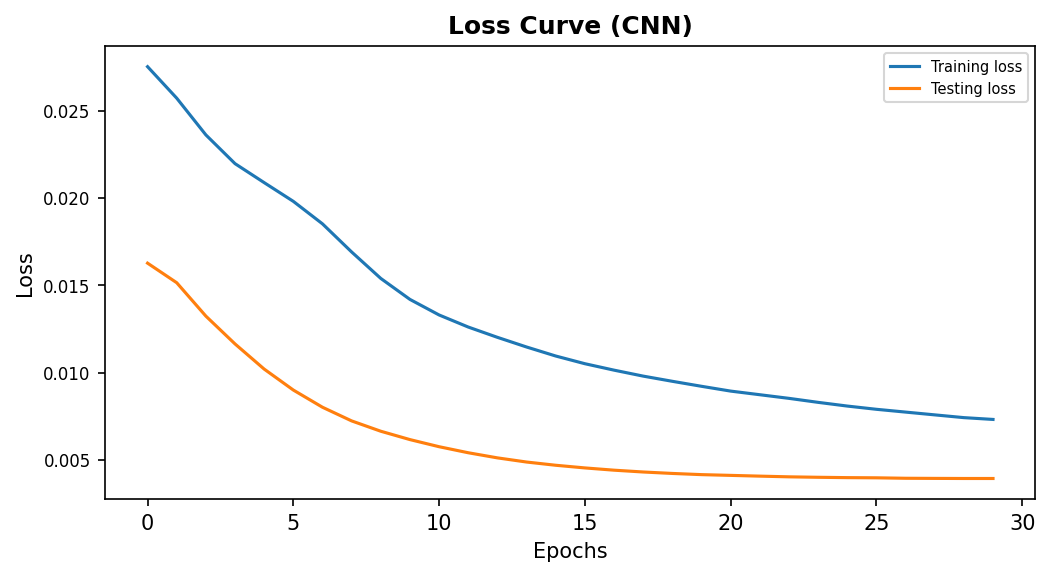

In [11]:
def smooth_curve(points, factor=0.8): #this function will make our plots more smooth
	smoothed_points = []
	for point in points:
		if smoothed_points:
			previous = smoothed_points[-1]
			smoothed_points.append(previous*factor+point*(1-factor))
		else:
			smoothed_points.append(point)
	return smoothed_points


# plotting the training and validation loss
plt.figure(figsize=(8,4),dpi=150)
plt.plot(smooth_curve(training_losses), label='Training loss')
plt.plot(smooth_curve(testing_losses), label='Testing loss')
plt.title('Loss Curve (CNN)',fontweight='bold')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.yticks(size=8)
plt.legend(prop={'size': 7})
plt.show()

Plotting predicted values against actual values

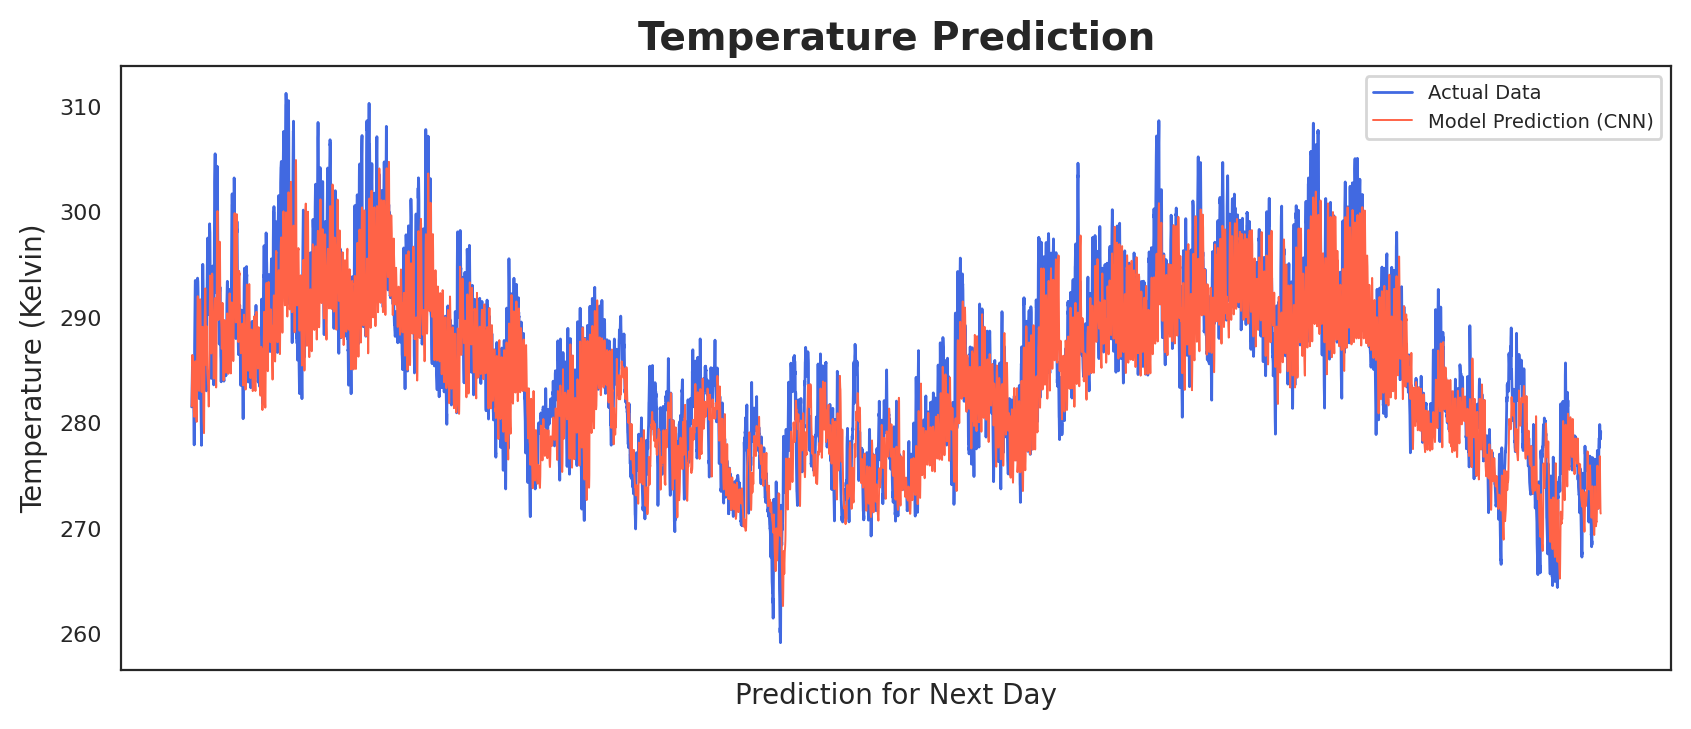

In [12]:
plt.figure(figsize = (10,4), dpi=200)
sb.set_style("white")    

sb.lineplot(x = original.index, y = original["Original"], label="Actual Data", color='royalblue',linewidth=1)
sb.lineplot(x = predict.index, y = predict["Predicted"], label="Model Prediction (CNN)", color='tomato',linewidth=0.7)
plt.title('Temperature Prediction', size = 14, fontweight='bold')
plt.xlabel("Prediction for Next Day", size = 10)
plt.ylabel("Temperature (Kelvin)", size = 10)
plt.xticks(ticks=[])
plt.yticks(size=8)
plt.legend(loc="upper right", prop={'size': 7})
plt.show()